<a href="https://colab.research.google.com/github/eeuuais/kaggle_comp/blob/main/(2_2)Interactive_Porto_Insights_A_Plot_ly_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Let us load in the relevant Python modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/kaggle_data/porto_train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
# taking a look at how many rows and columns the train dataset contains

rows = train.shape[0]
columns = train.shape[1]
print("The train dataset contains {0} rows and {1} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


1. 데이터 품질 확인
Null 또는 누락된 값 확인

품질 검사의 일환으로 다음과 같이 기차 데이터 세트에 null 값이 있는지 빠르게 살펴보겠습니다.

In [4]:
#any() applied twice to check run the isnull check across all columns
train.isnull().any().any()

False

- 우리의 null 값 검사는 False를 반환하지만 데이터가 "-1의 값은 기능이 관찰에서 누락되었음을 나타냅니다"로 설명되어 있기 때문에 이것이 실제로 이 사례가 종료되었음을 의미하지는 않습니다. 따라서 Porto Seguro가 단순히 데이터의 모든 null 값을 -1 값으로 전면 교체했다고 생각합니다. 이제 데이터에 누락된 값이 있는지 살펴보겠습니다.
- 여기에서 값에 -1이 포함된 열을 볼 수 있으므로 예를 들어 다음과 같이 먼저 모든 -1을 null로 대체할 수 있습니다.

In [5]:
train_copy = train
train_copy = train_copy.replace(-1, np.NaN)

다음으로 데이터 세트에서 누락된 값을 시각화하는 데 가장 유용하고 편리한 도구인 "Missingno" 패키지의 작성자인 상주 Kaggler의 Aleksey Bilogur를 사용할 수 있으므로 확인하십시오.

<AxesSubplot:>

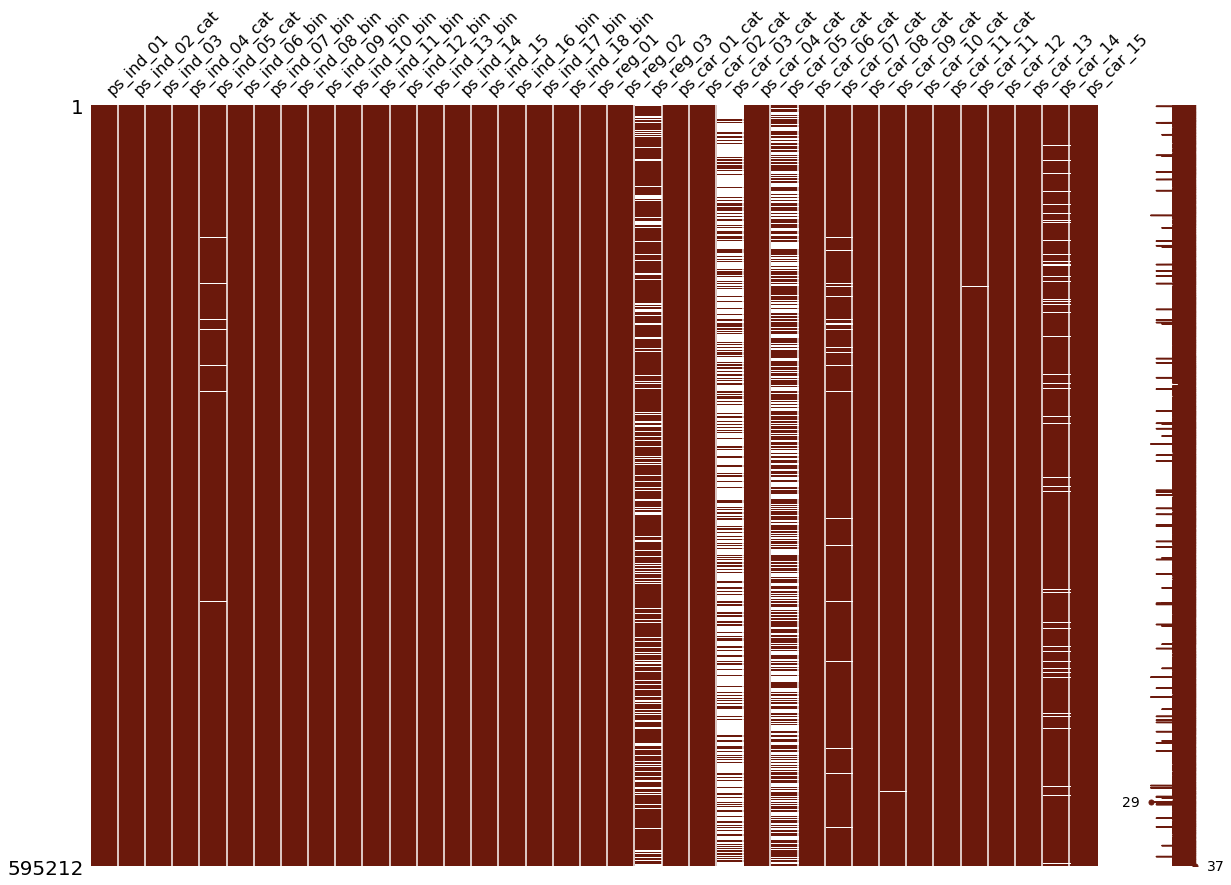

In [6]:
import missingno as msno

# Nullity or missing values by columns
msno.matrix(df=train_copy.iloc[:, 2:39], figsize=(20, 14),
            color = (0.42, 0.1, 0.05))

보시다시피 누락된 값은 이제 시각화할 때 훨씬 더 분명하고 명확해집니다. 여기서 빈 흰색 띠(누락된 데이터)는 수직의 어두운 빨간색 띠(비누락 데이터)에 중첩되어 데이터의 무효성을 반영합니다. 해당 열에서. 이 경우 총 59개의 기능 중 7개의 기능이 있음을 관찰할 수 있습니다(주석 섹션에서 Justin Nafe가 올바르게 지적한 대로 누락된 값이 있는 총 13개의 열이 있음). 실제로 null 값이 포함되었습니다. 이것은 missingno 매트릭스 플롯이 하나의 플롯에 약 40개의 홀수 기능에만 편안하게 맞을 수 있고 그 후에 일부 열이 제외될 수 있기 때문에 나머지 5개의 null 열이 제외되었기 때문입니다. 모든 null을 시각화하려면 figsize 인수를 변경하고 데이터 프레임을 분할하는 방법을 조정해 보십시오.

우리가 관찰할 수 있는 7개의 null 열에 대해 다음과 같이 여기에 나열됩니다.

ps_ind_05_cat | ps_reg_03 | ps_car_03_cat | ps_car_05_cat | ps_car_07_cat | ps_car_09_cat | ps_car_14

누락된 값의 대부분은 _cat 접미사가 붙은 열에서 발생합니다. ps_reg_03, ps_car_03_cat 및 ps_car_05_cat 열에 대해 더 자세히 기록해야 합니다. 흰색 밴드와 어두운 밴드의 비율을 보면 이 3개 열에서 대부분의 값이 누락되었음을 알 수 있으므로 null을 -1로 대체하는 것은 좋은 전략이 아닐 수 있습니다.

대상 변수 검사

데이터에 대해 일반적으로 수행되는 또 다른 표준 검사는 대상 변수와 관련되며, 이 경우 열 제목은 "대상"으로 편리합니다. 목표 값은 또한 클래스/라벨/정답의 이름으로 제공되며 지도 학습 모델에서 주어진 해당 데이터(이 경우 id 열을 제외한 모든 훈련 데이터)와 함께 지도 학습 모델에서 사용되어 가장 잘 매핑되는 기능을 학습합니다. 이 학습된 함수가 보이지 않는 새로운 데이터로 일반화하고 잘 예측할 수 있기를 바라며 데이터를 대상에 추가합니다.

In [7]:
data = [go.Bar(
    x = train['target'].value_counts().index.values,
    y = train['target'].value_counts().values,
    text = 'Distribution of target variable'
)]

layout = go.Layout(
    title = 'Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')
fig.show(renderer='colab')

음, 목표 변수가 다소 불균형하므로 염두에 두어야 할 사항이 될 수 있습니다. 불균형한 목표는

- 데이터 유형 확인

이 검사는 기차 세트가 어떤 종류의 데이터 유형으로 구성되어 있는지 확인하기 위해 수행됩니다. 제공된 데이터에 대한 더 나은 개요를 얻기 위해 정수, 문자 또는 부동 소수점. Python 시퀀스에서 고유 유형의 개수를 얻는 한 가지 트릭은 다음과 같이 Collections 모듈을 가져올 때 Counter 메서드를 사용하는 것입니다.

In [8]:
Counter(train.dtypes.values)

Counter({dtype('int64'): 49, dtype('float64'): 10})

위에서 언급했듯이 기차 데이터 세트를 구성하는 총 59개의 열이 있으며 이 확인에서 관찰할 수 있듯이 기능/열은 정수와 부동 소수점의 두 가지 데이터 유형으로만 구성됩니다.

주목해야 할 또 다른 점은 Porto Seguro가 "_bin", "_cat" 및 "_reg"와 같은 약어가 붙은 헤더가 있는 데이터를 실제로 제공했다는 것입니다. 여기서 그들은 _bin이 이진 기능을 나타내고 _cat이 나타내는 대략적인 설명을 제공했습니다. 나머지는 연속 또는 서수 기능인 반면 범주형 기능입니다. 여기서는 부동 소수점 값(아마도 연속 기능만)과 정수 데이터 유형(이진, 범주 및 서수 기능)을 살펴봄으로써 이를 조금 더 단순화할 것입니다.

In [9]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

상관관계 도표
먼저 선형 상관 관계 플롯을 생성하여 기능이 다음 기능과 선형적으로 어떻게 상관되는지 빠르게 살펴보고 여기에서 통찰력을 얻기 시작할 수 있습니다. 이 시점에서 seaborn 통계 시각화 패키지를 사용하여 상관 관계 값의 히트맵을 그릴 것입니다. 편리하게도 Pandas 데이터 프레임에는 Pearson 상관 관계를 계산하는 corr() 메서드가 내장되어 있습니다. 또한 Seaborn의 상관 관계 플롯 호출 방식도 편리합니다. 말 그대로 "히트맵"이라는 단어

플로트 기능의 상관 관계

<AxesSubplot:title={'center':'Pearson correlation of continuous features'}>

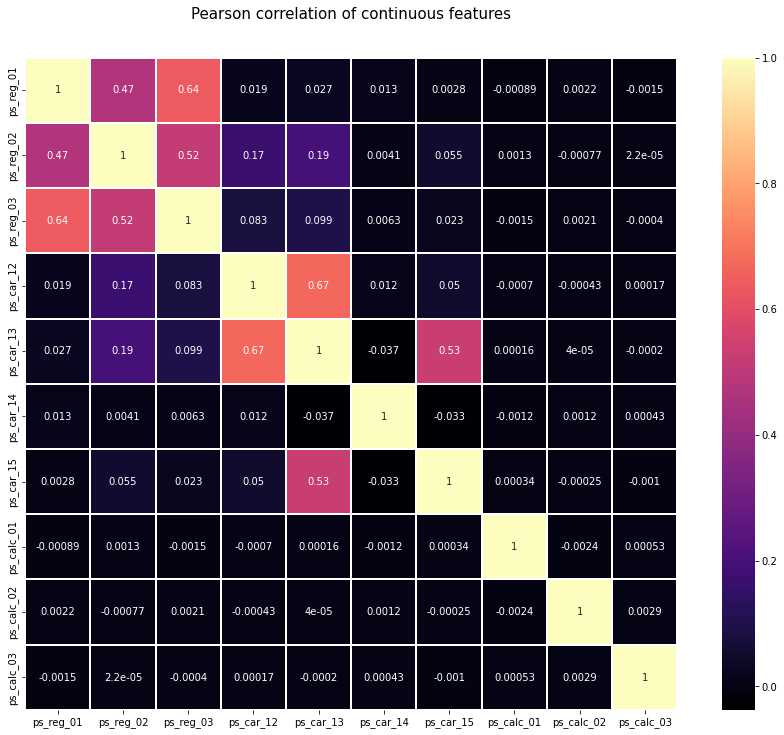

In [10]:
# Correlation of float features
colormap = plt.cm.magma
plt.figure(figsize = (16, 12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True,
            cmap=colormap, linecolor='white', annot=True)

상관 관계 도표에서 대부분의 기능이 서로 상관 관계가 없거나 전혀 없음을 알 수 있습니다. 이것은 나중에 우리의 추가 조사를 보증할 꽤 흥미로운 관찰입니다. 현재 양의 선형 상관관계를 나타내는 쌍을 이루는 기능은 다음과 같습니다.

(ps_reg_01, ps_reg_03)

(ps_reg_02, ps_reg_03)

(ps_car_12, ps_car_13)

(ps_car_13, ps_car_15)

정수 기능의 상관 관계

interger 데이터 유형의 열에 대해 이제 Plotly 라이브러리를 사용하여 상관 관계 값의 히트맵을 대화식으로 생성할 수 있는 방법을 보여 드리겠습니다. 이전 Plotly 플롯과 마찬가지로 단순히 "go.Heatmap"을 호출하여 히트맵 개체를 생성합니다. 여기서 우리는 세 개의 서로 다른 축에 값을 제공해야 합니다. 여기서 x축과 y축은 열 이름을 가져오고 상관 값은 z축에서 제공됩니다. colorscale 속성은 히트맵에서 볼 수 있는 다양한 색상 팔레트에 해당하는 키워드를 사용합니다. 이 예에서는 Grays colorscale을 사용했습니다(다른 색상에는 Portland 및 Viridis가 포함됩니다. 직접 사용해 보십시오).

In [11]:
#train_int = train_int.drop(["id", "target"], axis=1)
# colormap = plt.cm.bone
# plt.figure(figsize=(21,16))
# plt.title('Pearson correlation of categorical features', y=1.05, size=15)
# sns.heatmap(train_cat.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)
data = [go.Heatmap(
      z=train_int.corr().values,
      x=train_int.columns.values,
      y=train_int.columns.values,
      colorscale='Viridis',
      reversescale = False,
      # text = True , # 삭제
      opacity = 1.0 )
]

layout = go.Layout(
    title='Pearson Correlation of Integer-type features',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')
fig.show(renderer='colab')

유사하게, 서로 선형 상관관계가 전혀 없는 엄청난 수의 열이 있음을 관찰할 수 있습니다. 이는 상관관계 도표에서 상당히 많은 0 값 셀을 관찰한다는 사실에서 분명합니다. 이는 특히 PCA(Principal Component Analysis)와 같은 차원 축소 변환을 수행하려는 경우 어느 정도의 상관 관계가 필요하므로 상당히 유용한 관찰입니다. 관심 있는 몇 가지 기능은 다음과 같습니다.

음의 상관 관계가 있는 기능: ps_ind_06_bin, ps_ind_07_bin, ps_ind_08_bin, ps_ind_09_bin

주목해야 할 한 가지 흥미로운 측면은 nullity에 대한 이전 분석에서 ps_car_03_cat 및 ps_car_05_cat에 많은 누락 또는 null 값이 포함되어 있음이 발견되었다는 것입니다. 따라서 이 두 가지 기능이 데이터에 대한 기본 진실을 실제로 반영하지 않을 수도 있지만 이러한 기반에서 서로에 대해 상당히 강력한 양의 선형 상관관계를 보인다는 것은 놀라운 일이 아닙니다.

Mutual information plots
상호 정보는 대상 변수와 계산된 해당 기능 간의 상호 정보를 검사할 수 있으므로 또 다른 유용한 도구입니다. 분류 문제의 경우 두 개의 무작위 변수 사이의 종속성을 측정하고 0(임의 변수가 서로 독립적인 경우)에서 더 높은 값(일부 종속성을 나타냄)까지 범위를 측정하는 Sklearn의 mutual_info_classif 메서드를 편리하게 호출할 수 있습니다. 따라서 이것은 피처 내에 대상에서 얼마나 많은 정보가 포함될 수 있는지에 대한 아이디어를 제공하는 데 도움이 됩니다.

Mutual_info_classif 함수의 sklearn 구현은 "k-최근접 이웃 거리에서 엔트로피 추정을 기반으로 하는 비모수적 방법에 의존"한다고 알려줍니다. 여기 링크의 공식 sklearn 페이지에서 더 자세히 알아볼 수 있습니다.

In [12]:
mf = mutual_info_classif(train_float.values, train.target.values, n_neighbors=3, random_state=17)
print(mf)

[0.02599971 0.00767074 0.00617141 0.01855302 0.00158483 0.00338192
 0.01668813 0.0134428  0.01334669 0.01348572]


바이너리 기능 검사
검사할 수 있는 데이터의 또 다른 측면은 이진 값만 포함하는 열입니다. 즉, 값이 1 또는 0의 두 값 중 하나만 취하는 경우입니다. 계속해서 이러한 이진 값을 포함하는 모든 열을 저장한 다음 생성합니다. 다음과 같은 이진 값의 세로 막대 그래프:

In [13]:
bin_col = [col for col in train.columns if '_bin' in col]
zero_list = []
one_list = []
for col in bin_col:
  zero_list.append((train[col]==0).sum())
  one_list.append((train[col]==1).sum())

In [16]:
trace1 = go.Bar(
    x = bin_col,
    y = zero_list,
    name = 'Zero count'
)

trace2 = go.Bar(
    x = bin_col,
    y = one_list,
    name = 'One count'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    title='Count of 1 and 0 in binary variables'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')
fig.show(renderer='colab') 
#fig.show(fig, filename='stacked-bar')

- 여기서 우리는 0이 완전히 지배하는 ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin의 4가지 기능이 있음을 관찰합니다. 이는 대상과 비교하여 다른 클래스에 대한 많은 정보를 포함하지 않기 때문에 이러한 기능이 전혀 유용한지 여부에 대한 질문을 제기합니다.

- 범주형 및 순서형 기능 검사 : 
접미사 "_cat"에 따라 범주형이라고 하는 기능을 먼저 살펴보겠습니다.

- Random Forest를 통한 기능 중요도 : 
이제 Random Forest Classifier로 교육 데이터를 맞추는 Random Forest 모델을 구현하고 모델이 교육을 마친 후 기능 순위를 살펴보겠습니다. 이것은 앙상블 모델(부트스트랩 집계에 적용된 약한 결정 트리 학습자의 앙상블)을 사용하는 빠른 방법으로, 유용한 기능 중요도를 얻는 데 많은 매개변수 조정이 필요하지 않으며 대상 불균형에 매우 강합니다. 다음과 같이 Random Forest를 호출합니다.

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150,
                            max_depth=8,
                            min_samples_leaf=4, 
                            max_features=0.2,
                            n_jobs=-1,
                            random_state=0)

rf.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


- Plot.ly 기능 중요도의 산점도

Random Forest를 훈련한 후 "featureimportances" 속성을 호출하여 기능 중요도 목록을 얻고 다음 Plotly 플롯인 Scatter 플롯을 그릴 수 있습니다.

여기에서 Scatter 명령을 호출하고 이전 Plotly 플롯에 따라 y축과 x축을 정의해야 합니다. 그러나 산점도에서 주목해야 할 한 가지는 마커 속성입니다. 포함된 스캐터 포인트의 크기, 색상 및 배율을 정의하고 제어하는 것은 마커 속성입니다.

In [22]:
# Scatter plot 
trace = go.Scatter(
    y = rf.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = rf.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')
fig.show(renderer='colab') 

또한 다음과 같이 동일한 플롯 막대 그래프를 통해 중요도 순으로 순위가 매겨진 모든 기능의 정렬된 목록을 표시할 수 있습니다.

In [28]:
x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Random Forest Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
#         domain=[0, 0.85],
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')
fig1.show(renderer='colab') 

- 의사 결정 트리 시각화

자주 사용되는 또 다른 흥미로운 트릭이나 기술은 모델이 내린 결정이나 나뭇가지를 시각화하는 것입니다. 간단하게 하기 위해 의사결정 트리(max_depth = 3)에 적합하므로 의사결정 분기에서 3개 수준만 볼 수 있습니다. 공책.

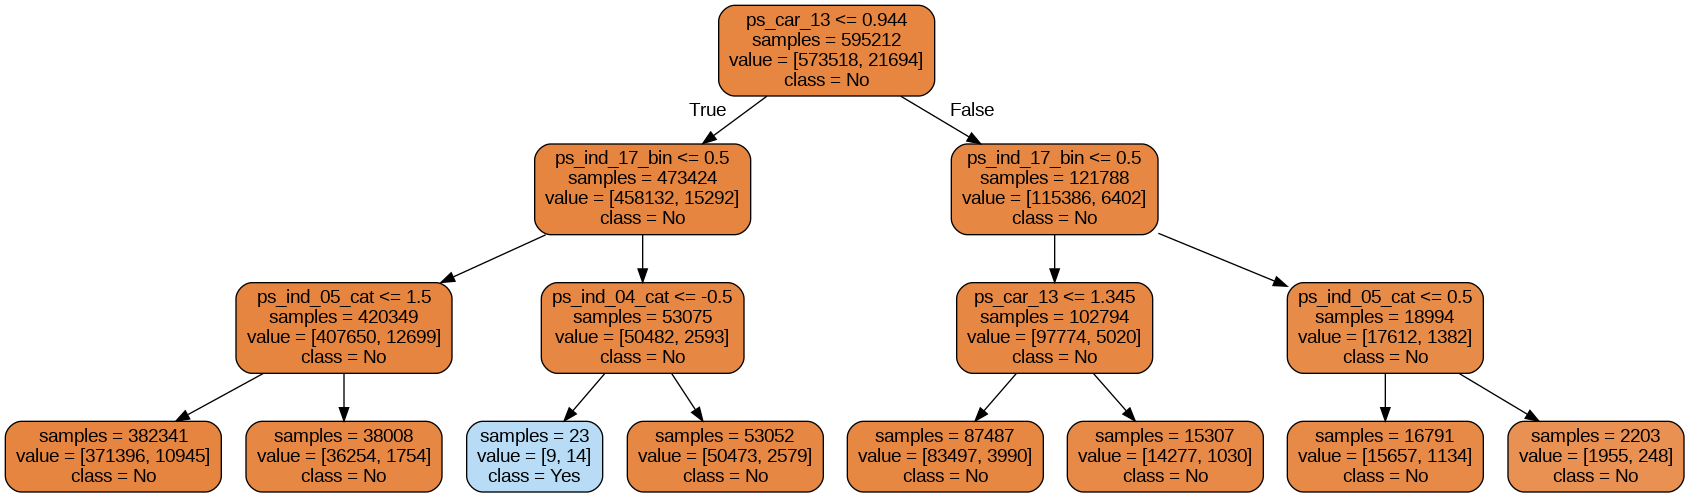

In [29]:
from sklearn import tree
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
import re

decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(train.drop(['id', 'target'],axis=1), train.target)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 4,
                              impurity = False,
                              feature_names = train.drop(['id', 'target'],axis=1).columns.values,
                              class_names = ['No', 'Yes'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
img.save('sample-out.png')
PImage("sample-out.png",)

Gradient Boosting 모델을 통한 기능 중요도
호기심을 위해 기능 중요도를 얻는 다른 학습 방법을 시도해 보겠습니다. 이번에는 훈련 데이터에 맞추기 위해 Gradient Boosting 분류기를 사용합니다. Gradient Boosting은 순방향 단계 방식으로 진행되며, 각 단계에서 회귀 트레스는 손실 함수의 기울기에 맞춰집니다(Sklearn 구현에서 기본값은 편차임).

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, max_depth =3, min_samples_leaf=4, max_features=0.2, random_state=0)
gb.fit(train.drop(['id', 'target'], axis=1), train.target)
features = train.drop(['id', 'target'], axis=1).columns.values
print("----- Training Done -----")

----- Training Done -----


In [32]:
# Scatter plot 
trace = go.Scatter(
    y = gb.feature_importances_,
    x = features,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gb.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = features
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Machine Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [34]:
x, y = (list(x) for x in zip(*sorted(zip(gb.feature_importances_, features), 
                                                            reverse = False)))
trace2 = go.Bar(
    x=x ,
    y=y,
    marker=dict(
        color=x,
        colorscale = 'Viridis',
        reversescale = True
    ),
    name='Gradient Boosting Classifer Feature importance',
    orientation='h',
)

layout = dict(
    title='Barplot of Feature importances',
     width = 900, height = 2000,
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
    ))

fig1 = go.Figure(data=[trace2])
fig1['layout'].update(layout)
py.iplot(fig1, filename='plots')
fig1.show(renderer='colab') 

흥미롭게도 우리는 Random Forest와 Gradient Boosted 학습 모델 모두에서 두 모델이 선택한 가장 중요한 기능이 열인 ps_car_13이라는 것을 관찰했습니다.

이 특정 기능은 추가 조사가 필요하므로 자세히 살펴보겠습니다.

- 결론
우리는 Null 값과 데이터 품질을 검사하여 Porto Seguro 데이터 세트를 상당히 광범위하게 검사하고, 기능 간의 선형 상관 관계를 조사하고, 일부 기능 분포를 검사하고, 몇 가지 학습 모델(Random Forest 및 Gradient Boosting 분류기)을 구현했습니다. 모델이 중요하다고 생각하는 기능을 식별하기 위해.